In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [3]:
from cibmtr.settings import test_data_path, train_data_path

test = pd.read_csv(test_data_path)
print("Test shape:", test.shape)

train = pd.read_csv(train_data_path)
print("Train shape:", train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


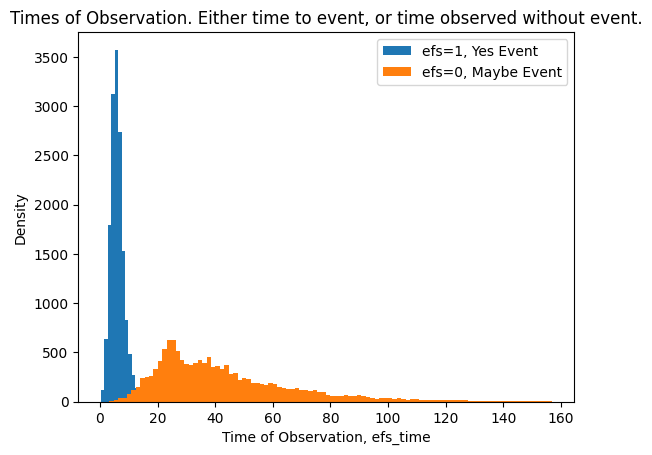

In [4]:
plt.hist(train.loc[train.efs == 1, "efs_time"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs == 0, "efs_time"], bins=100, label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

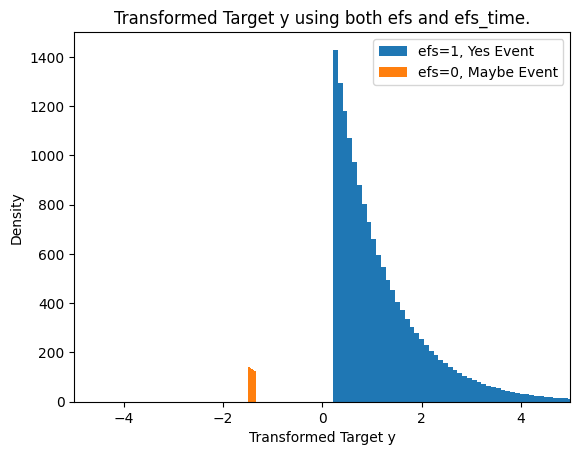

In [5]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs == 1, "efs_time"].max()
mn = train.loc[train.efs == 0, "efs_time"].min()
train.loc[train.efs == 0, "y"] = train.loc[train.efs == 0, "y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs == 0, "y"] += 2 * len(train)
train.y = train.y / train.y.max()
train.y = np.log(train.y)
train.y -= train.y.mean()
train.y *= -1.0

plt.hist(train.loc[train.efs == 1, "y"], bins=100, label="efs=1, Yes Event")
plt.hist(train.loc[train.efs == 0, "y"], bins=100, label="efs=0, Maybe Event")
plt.xlim((-5, 5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [6]:
RMV = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [7]:
CATS = []
for c in FEATURES:
    if train[c].dtype == "object":
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
        CATS.append(c)
    elif not "age" in c:
        train[c] = train[c].astype("str")
        test[c] = test[c].astype("str")
        CATS.append(c)
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 55 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [8]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train, test], axis=0, ignore_index=True)
# print("Combined data shape:", combined.shape )

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CATS:
        # LABEL ENCODE
        combined[c], _ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        # combined[c] = combined[c].astype("category")

        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f"{c} has ({n}) unique values")

        CAT_SIZE.append(mx + 1)
        CAT_EMB.append(int(np.ceil(np.sqrt(mx + 1))))
    else:
        if combined[c].dtype == "float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype == "int64":
            combined[c] = combined[c].astype("int32")

        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c] - m) / s
        combined[c] = combined[c].fillna(0)

        NUMS.append(c)

train = combined.iloc[: len(train)].copy()
test = combined.iloc[len(train) :].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
hla_match_c_high has (4) unique values
hla_high_res_8 has (8) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
hla_low_res_6 has (6) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
hla_high_res_6 has (7) unique values
cmv_status has (5) unique values
hla_high_res_10 has (9) unique values
hla_match_dqb1_high has (4) unique values
tce_imm_match has (9) unique values
hla_nmdp_6 has (6) unique values
hla_match_c_low has (4) unique values
rituximab has (3) unique values
hla_match_drb1_low has (3) unique values
hla_match_dqb1_low has (4) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7)

In [34]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,-1.358108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,42.356,-1.437594
1,1,1,0,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1.952325,0,0,0,0.238463,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,1.0,4.672,1.479320
2,2,0,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.000000,0,0,0,-0.220605,0,2,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,19.793,-1.354672
3,3,2,0,1,0,1,1,0,0,0,0,0,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,1,0,3,0,1,1,1,0,0,-0.870869,0,0,0,0.216711,0,3,0,3,0,2,0,0,1,1,0,0,0,0,0,0,0,0.0,102.349,-1.497155
4,4,2,0,0,0,1,1,0,0,0,1,0,0,0,4,0,0,1,0,0,1,0,0,0,0,1,0,1,1,4,0,0,0,0,0,0,0.937392,0,0,0,-0.421908,0,4,0,0,0,3,2,0,0,1,1,1,0,0,0,0,0,0.0,16.223,-1.345944


In [70]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset


class CustomDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cat_values = torch.empty(len(CATS), dtype=torch.long)
        cat_values[:] = torch.from_numpy(self.data.iloc[idx][CATS].values)

        num_values = torch.empty(len(NUMS), dtype=torch.float)
        num_values[:] = torch.from_numpy(self.data.iloc[idx][NUMS].values)
        return (
            cat_values,
            num_values,
            torch.tensor(self.data.iloc[idx]["y"], dtype=torch.float),
        )

In [73]:
train_dataset = CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size=8192, shuffle=True)

In [74]:
%%time
b = next(iter(train_loader))

CPU times: user 3.61 s, sys: 970 μs, total: 3.62 s
Wall time: 3.61 s


In [82]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cat_embeddings = nn.ModuleList(
            nn.Embedding(cat_size, cat_emb_size)
            for cat_size, cat_emb_size in zip(CAT_SIZE, CAT_EMB)
        )
        self.dense1 = nn.Linear(2 + sum(CAT_EMB), 256)
        self.dense2 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 1)

    def forward(self, cat_features, num_features):
        inp = torch.cat(
            [
                self.cat_embeddings[i](cat_features[:, i])
                for i in range(cat_features.shape[1])
            ],
            dim=1,
        )
        inp = torch.cat([inp, num_features], dim=1)
        x = self.dense1(inp)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.output(x)
        return x.squeeze()

In [83]:
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




FOLDS = 5
EPOCHS = 2

batch_size = 512
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train))


for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    m = Model().to(device)
    opt = optim.AdamW(m.parameters(), lr=0.01)
    
    train_ds = CustomDataset(train.iloc[train_idx])
    val_ds = CustomDataset(train.iloc[val_idx])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    for epoch in range(EPOCHS):
        losses = []
        for cat_features, num_features, gt in tqdm(train_loader):
            opt.zero_grad()
            
            cat_features, num_features, gt = (
                cat_features.to(device),
                num_features.to(device),
                gt.to(device),
            )
            pred = m(cat_features, num_features)
            loss = F.mse_loss(pred, gt)
            loss.backward()
            # print(m.dense1.weight.grad)
            opt.step()
            losses.append(loss.item())

        val_losses = []
        for idx, (cat_features, num_features, gt) in enumerate(val_loader):
            cat_features, num_features, gt = (
                cat_features.to(device),
                num_features.to(device),
                gt.to(device),
            )
            pred = m(cat_features, num_features)
            loss = F.mse_loss(pred, gt)
            val_losses.append(loss.item())

            oof_preds[val_idx[idx*batch_size:(idx+1)*batch_size]] = pred.detach().cpu().numpy()
        print(f"Fold {fold} Epoch {epoch} Train Loss: {np.mean(losses)} Val Loss: {np.mean(val_losses)}")

  0%|          | 0/45 [00:00<?, ?it/s]

Fold 0 Epoch 0 Train Loss: 2.341398686832852 Val Loss: 1.976495345433553


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 0 Epoch 1 Train Loss: 1.8953583770328097 Val Loss: 1.903406451145808


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 1 Epoch 0 Train Loss: 2.6503980848524304 Val Loss: 1.9803099930286407


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 1 Epoch 1 Train Loss: 1.9537910646862453 Val Loss: 1.9757225811481476


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 2 Epoch 0 Train Loss: 2.4006300422880384 Val Loss: 1.969469557205836


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 2 Epoch 1 Train Loss: 1.924150816599528 Val Loss: 1.8877233763535817


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 3 Epoch 0 Train Loss: 2.3508292092217338 Val Loss: 2.0628582537174225


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 3 Epoch 1 Train Loss: 1.9478552023569742 Val Loss: 1.9728007912635803


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 4 Epoch 0 Train Loss: 2.3219352377785576 Val Loss: 1.9466970165570576


  0%|          | 0/45 [00:00<?, ?it/s]

Fold 4 Epoch 1 Train Loss: 1.9049408488803439 Val Loss: 1.8996240198612213


In [84]:
from cibmtr.metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = oof_preds
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for NN =",m)








Overall CV for NN = 0.6535113673456517
